# bc_parser.py
This notebook parses barcodes from Illumina sequencing data. Input is listed in [data/samplelist.csv](./data/samplelist.csv). Output is stored in the [results/](./results/) directory. For more details, see [README](./README.md).

Imports

In [1]:
import Bio.SeqIO
import gzip
import pandas as pd
import plotnine as p9
import regex as re

## Paramaters

In [2]:
barcode_mismatch = 2 # number of mismatch allowed in upstream or downstream sequence
read_limit = 20000
nucleotides_allowed = 'ACTG'

Visualization styles

In [3]:
# Dutch-field from https://gist.github.com/afcotroneo/ca9716f755128b5e9b2ed1fe4186f4df
palette = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]
# Minimal plotnine theme
p9.theme_set(p9.theme_minimal())

## Input data
### Samples

In [4]:
samplelist = './data/samplelist.csv'
samples_df = pd.read_csv(samplelist, comment='#')
display(samples_df)

,sample,fastq_file,bc_len,upstream_seq,downstream_seq
0,BC20_Perth09_bcNP_RepA_03,/Users/dbacsik/Downloads/raw_seqs/SWGG9B_raw/S...,16,AGGAATACGATAACTAATAGG,NaN
1,BC20_Perth09_bcNP_RepB_04,/Users/dbacsik/Downloads/raw_seqs/SWGG9B_raw/S...,16,AGGAATACGATAACTAATAGG,NaN


Check sample input conforms to requirements.  
Requirements:  
* `sample` (sample name) is unique
* There is exactly 1 `fastq.gz` file listed in `fastq_file` column

In [5]:
assert samples_df['sample'].is_unique, \
    "Sample names are not unique"
assert (samples_df['fastq_file'].str.count('.fastq.gz') == 1).all(), \
    "One (1) fastq.gz file per sample required."

### Parse barcodes

In [6]:
results = list()
for sample, df in samples_df.iterrows():
    print(f"Parsing barcodes for {df['sample']} from {df['fastq_file']}.")
    print("Search parameters are:")
    print(f"\tBarcode length: {df['bc_len']}")
    if pd.notnull(df['upstream_seq']):
        upstream_seq = df['upstream_seq']
        print(f"\tUpstream sequence: {upstream_seq}")
    else:
        print("\tUpstream sequence: not specified")
        upstream_seq = ''
    if pd.notnull(df['downstream_seq']):
        downstream_seq = df['downstream_seq']
        print(f"\tDownstream sequence: {downstream_seq}")
    else:
        print("\tDownstream sequence: not specified")
        downstream_seq = ''
    ### Build regex search pattern
    pattern = (f'(?:{df["upstream_seq"]}){{e<={barcode_mismatch}}}' +  # match upstream
                  f'([{nucleotides_allowed}]{{{df["bc_len"]}}})')  # match and capture barcode
    print(f"The search pattern for {df['sample']} will be:\n\t{pattern}")
    print("Parsing barcodes...")
    sample_results = list()
    count = 0
    with gzip.open(df['fastq_file'], "rt") as handle:
        for record in Bio.SeqIO.parse(handle, "fastq"):
            if count < read_limit:
                search_seq = record.seq
                seq_len = len(search_seq)
                result = re.search(pattern, str(search_seq))
                if result == None:
                    match = 'failed_parse'
                    barcode = 'failed_parse'
                else:
                    barcode = result.group(1)
                    match = result.group(0)
                sample_results.append((df['sample'],
                                      'barcode'))
                results.append((df['sample'],
                                record.id,
                                str(record.seq),
                                seq_len,
                                match,
                                barcode))
                count+=1
            else:
                break
    print("Parsing done.")
    sample_df = pd.DataFrame(sample_results)
    sample_df.columns = ['sample','barcode']
    barcodes_csv = 'results/' + df['sample']+'_barcodes.csv'
    print(f"Writing barcodes to {barcodes_csv}")
    sample_df.to_csv(
        barcodes_csv,
        index=False,
        compression='gzip')
    print('\n')

print("CSV done.")
barcodes_df = pd.DataFrame(results)
barcodes_df.columns = ['sample','record_id','sequence','sequence_length','match','barcode']
display(barcodes_df)



Parsing barcodes for BC20_Perth09_bcNP_RepA_03 from /Users/dbacsik/Downloads/raw_seqs/SWGG9B_raw/SWGG9B_3.fastq.gz.
Search parameters are:
	Barcode length: 16
	Upstream sequence: AGGAATACGATAACTAATAGG
	Downstream sequence: not specified
The search pattern for BC20_Perth09_bcNP_RepA_03 will be:
	(?:AGGAATACGATAACTAATAGG){e<=2}([ACTG]{16})
Parsing barcodes...
Parsing done.
Writing barcodes to results/BC20_Perth09_bcNP_RepA_03_barcodes.csv


Parsing barcodes for BC20_Perth09_bcNP_RepB_04 from /Users/dbacsik/Downloads/raw_seqs/SWGG9B_raw/SWGG9B_4.fastq.gz.
Search parameters are:
	Barcode length: 16
	Upstream sequence: AGGAATACGATAACTAATAGG
	Downstream sequence: not specified
The search pattern for BC20_Perth09_bcNP_RepB_04 will be:
	(?:AGGAATACGATAACTAATAGG){e<=2}([ACTG]{16})
Parsing barcodes...
Parsing done.
Writing barcodes to results/BC20_Perth09_bcNP_RepB_04_barcodes.csv


CSV done.


,sample,record_id,sequence,sequence_length,match,barcode
0,BC20_Perth09_bcNP_RepA_03,0a1e1350-57c2-49b1-8a7e-52d0bfc6ab7d,CCATGAGTGATAACACTGCGGCCAACTTACTTCTGACAACGATCGA...,2054,failed_parse,failed_parse
1,BC20_Perth09_bcNP_RepA_03,b425ef2f-4885-4d3a-b7b2-3587fe63cb76,CGATACCAAATACTGTTCTTCTAGTGTAGCCGTAGTTAGGCCACCA...,3317,failed_parse,failed_parse
2,BC20_Perth09_bcNP_RepA_03,2747fb19-2901-4023-a5c2-6c8f224984fa,CCCAACGAATTAAGGCGAGTTACATGATCCCCCATGTTGTGCAAAA...,1061,failed_parse,failed_parse
3,BC20_Perth09_bcNP_RepA_03,7978d319-8588-4a77-9574-ecc4fb81551c,ACCAGAGGACAAGAGCTCTTGTTCGAACTGGAATGGAATCCCAGAA...,4587,CGAGGAATACGATAACTAATAGGCAATTGGAGCGCTTGG,CAATTGGAGCGCTTGG
4,BC20_Perth09_bcNP_RepA_03,c1b8864c-9f6e-4046-9b14-e20099c1f11c,GCAGCATTGCGCCAAGCAGGTAGGCAAGATTTGTGAGCAACTGATC...,1014,failed_parse,failed_parse
...,...,...,...,...,...,...
9391,BC20_Perth09_bcNP_RepB_04,2b25f456-3f24-45e1-9895-004687d10f97,CGACTGGGTGAGCAAAAACAGGAAGGCAAAATGCCGCAAAAAGAAA...,2519,failed_parse,failed_parse
9392,BC20_Perth09_bcNP_RepB_04,0a71fd98-912f-4153-b5c5-a4ec8f25d836,TTCCGGAAAGGACGTGGAAGTGGCCCCTTCAGGGTCAAGGAAGGCA...,4626,failed_parse,failed_parse
9393,BC20_Perth09_bcNP_RepB_04,43040b6f-f668-4892-a176-0ffa539ab99e,TTCCGTCCATTCTCACCTCTCCAAAAATTTCAATCGTTGATCCCCC...,4635,failed_parse,failed_parse
9394,BC20_Perth09_bcNP_RepB_04,eab5eac6-f1c9-4baf-b250-972037544284,ACCATACCGGCCTTTGAGTGAGCTGATACCACTCACCGCAGCCGAA...,4653,failed_parse,failed_parse


## Quality control
### Barcodes parsed per sample
Plot number of reads with barcode successfully parsed per sample

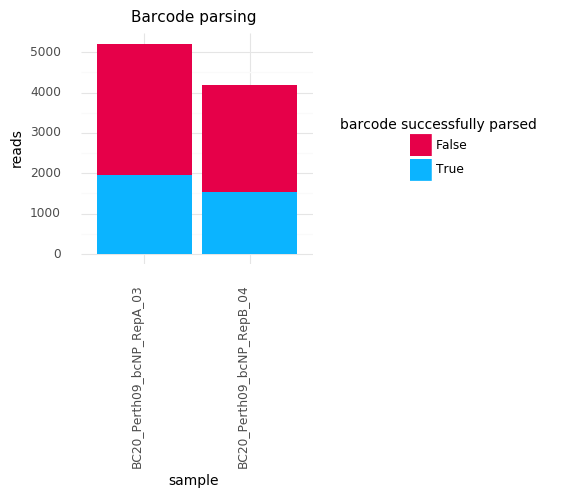

<ggplot: (322101217)>

In [7]:
parsing_qc = (p9.ggplot(barcodes_df) +
              p9.aes(x='sample',
                     fill='barcode != "failed_parse"') +
              p9.geom_bar(stat='count') +
              p9.ggtitle('Barcode parsing') +
              p9.labs(x='sample',
                      y='reads',
                      fill='barcode successfully parsed') +
              p9.theme(figure_size=(3,3),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=90, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(palette))

display(parsing_qc)

### Counts per barcode

In [8]:
bc_counts = (
    barcodes_df
    .groupby(['sample'])
    ['barcode']
    .value_counts()
    .reset_index(name='count')
)

bc_per_lib = (
    bc_counts
    .groupby(['sample'])
    ['count']
    .sum()
    .reset_index(name='sample_total')
)

bc_counts = pd.merge(
    left=bc_counts,
    right=bc_per_lib,
    on=['sample'],
    how='left',
    validate='many_to_one'
)

bc_counts['frequency'] = (
    bc_counts['count'] / bc_counts['sample_total']
)

display(bc_counts)

,sample,barcode,count,sample_total,frequency
0,BC20_Perth09_bcNP_RepA_03,failed_parse,3259,5205,0.626129
1,BC20_Perth09_bcNP_RepA_03,AAGAAAAGTATCTACC,111,5205,0.021326
2,BC20_Perth09_bcNP_RepA_03,ACATATGTACAACCTC,89,5205,0.017099
3,BC20_Perth09_bcNP_RepA_03,CTAATTACGAACACGA,87,5205,0.016715
4,BC20_Perth09_bcNP_RepA_03,TCAAAAAACAACAACG,87,5205,0.016715
...,...,...,...,...,...
677,BC20_Perth09_bcNP_RepB_04,TTAATGATGGGTCGCA,1,4191,0.000239
678,BC20_Perth09_bcNP_RepB_04,TTAGTTATTTAACCAC,1,4191,0.000239
679,BC20_Perth09_bcNP_RepB_04,TTCATGCATGACGCGG,1,4191,0.000239
680,BC20_Perth09_bcNP_RepB_04,TTGGACAATGGGGGAG,1,4191,0.000239


/Users/dbacsik/.local/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 27'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


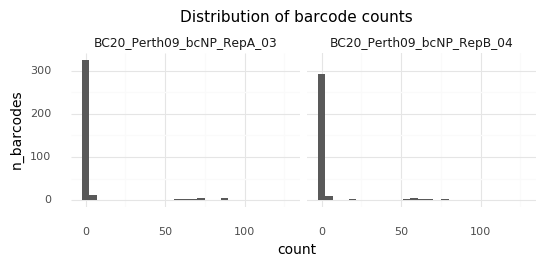

<ggplot: (322475254)>

In [9]:
barcode_distribution = (
    p9.ggplot(bc_counts.query('barcode != "failed_parse"')) +
    p9.aes(x='count') +
    p9.geom_histogram() +
    p9.facet_grid('~sample') +
    p9.ggtitle('Distribution of barcode counts') +
    p9.labs(x='count',
            y='n_barcodes') +
    p9.theme(figure_size=(6, 2),
             plot_title=p9.element_text(size=11),
             axis_title=p9.element_text(size=10),
             axis_text_x=p9.element_text(size=8),
             axis_text_y=p9.element_text(size=8))
   )

display(barcode_distribution)

### Barcode ranks

In [10]:
bc_ranks = bc_counts.query('barcode != "failed_parse"')
bc_ranks['rank'] = bc_ranks.groupby('sample')['count'].rank(ascending=False, method='first')
display(bc_ranks)

/Users/dbacsik/Documents/software/conda/envs/BloomLab_v3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sample,barcode,count,sample_total,frequency,rank
1,BC20_Perth09_bcNP_RepA_03,AAGAAAAGTATCTACC,111,5205,0.021326,1.0
2,BC20_Perth09_bcNP_RepA_03,ACATATGTACAACCTC,89,5205,0.017099,2.0
3,BC20_Perth09_bcNP_RepA_03,CTAATTACGAACACGA,87,5205,0.016715,3.0
4,BC20_Perth09_bcNP_RepA_03,TCAAAAAACAACAACG,87,5205,0.016715,4.0
5,BC20_Perth09_bcNP_RepA_03,TACACTACAATAGGCA,85,5205,0.016330,5.0
...,...,...,...,...,...,...
677,BC20_Perth09_bcNP_RepB_04,TTAATGATGGGTCGCA,1,4191,0.000239,317.0
678,BC20_Perth09_bcNP_RepB_04,TTAGTTATTTAACCAC,1,4191,0.000239,318.0
679,BC20_Perth09_bcNP_RepB_04,TTCATGCATGACGCGG,1,4191,0.000239,319.0
680,BC20_Perth09_bcNP_RepB_04,TTGGACAATGGGGGAG,1,4191,0.000239,320.0


/Users/dbacsik/.local/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 600 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


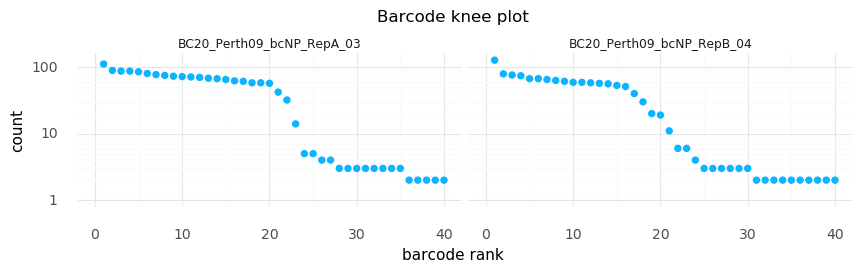

<ggplot: (-9223372036532674749)>

In [11]:
knee_plot = (
    p9.ggplot(bc_ranks) +
    p9.aes(x='rank',
           y='count') +
    p9.geom_point(size=2, color=palette[1]) +
    p9.facet_grid('~sample') +
    p9.ggtitle('Barcode knee plot') +
    p9.labs(x='barcode rank',
            y='count') +
    p9.scale_x_continuous(limits=[0,40]) +
    p9.scale_y_log10() +
    p9.theme(figure_size=(10, 2),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=11),
             axis_text_x=p9.element_text(size=10),
             axis_text_y=p9.element_text(size=10))
   )

display(knee_plot)